# Replication Notebook — ICU Example (Section 3)

This notebook reproduces the real-data ICU example from Section 3
(and Appendix C.1) of the paper:

*“The choice of reference group can reverse conclusions in the
Oaxaca–Blinder decomposition.”*

The goal is to replicate the healthcare application in which we examine the gender gap in ICU mortality and compute the Oaxaca–Blinder decomposition under both reference group choices for different sub-samples.

## Data (not included)

The analysis uses the PhysioNet ICU dataset.

Due to data-use and redistribution restrictions, the raw dataset is not included in this repository. You must download it yourself (see `data/README.md` for instructions).

After downloading and extracting the files, your project directory
should look like:

```project-root/
└── archive/
    ├── Outcomes-a.txt
    └── set-a/
        └── set-a/
            ├── 132539.txt
            ├── 132540.txt
            ├── ...
```
Once this structure is in place, run the notebook from top to bottom
to reproduce the results.


In [8]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
from typing import List, Dict, Any
from scipy.stats import norm

In [10]:
def add_const(X: pd.DataFrame) -> pd.DataFrame:
    """
    Add an intercept column to X.
    """
    return sm.add_constant(X, has_constant="add")


def oaxaca_twofold_fixed_direction(
    df: pd.DataFrame,
    y_col: str,
    x_cols: List[str],
    group_col: str,
    high_group_value: int = 0,
) -> Dict[str, Any]:
    """
    Two-fold Oaxaca–Blinder decomposition with a fixed direction.

    Computes:
        difference = mean(Y_high_group) - mean(Y_low_group)

    where:
        high_group = df[group_col] == high_group_value
        low_group  = df[group_col] != high_group_value

    and returns decompositions under two references:
      - ref='high'   : explained_highref   = (Xh - Xl) @ b_h
                       unexplained_highref = Xl @ (b_h - b_l)
      - ref='low'    : explained_lowref    = (Xh - Xl) @ b_l
                       unexplained_lowref  = Xh @ (b_h - b_l)

    Parameters
    ----------
    df : pd.DataFrame
        Input data.
    y_col : str
        Outcome column name.
    x_cols : list of str
        List of covariate names.
    group_col : str
        Name of binary group column.
    high_group_value : int, default 0
        Value in group_col considered the "high" group in the difference
        (e.g. 0 for men if female==1).

    Returns
    -------
    dict with keys:
        difference
        explained_highref, unexplained_highref
        explained_lowref,  unexplained_lowref
    """

    high = df[df[group_col] == high_group_value].copy()
    low  = df[df[group_col] != high_group_value].copy()

    if high.empty or low.empty:
        return {
            "difference": np.nan,
            "explained_highref": np.nan,
            "unexplained_highref": np.nan,
            "explained_lowref": np.nan,
            "unexplained_lowref": np.nan,
        }

    Xh, yh = add_const(high[x_cols]), high[y_col]
    Xl, yl = add_const(low[x_cols]),  low[y_col]

    bh = sm.OLS(yh, Xh, missing="drop").fit().params
    bl = sm.OLS(yl, Xl, missing="drop").fit().params

    mean_Xh, mean_Xl = Xh.mean(), Xl.mean()

    # High - low gap in means
    difference = yh.mean() - yl.mean()

    # Reference = high group
    explained_highref   = float((mean_Xh - mean_Xl) @ bh)
    unexplained_highref = float(mean_Xl @ (bh - bl))

    # Reference = low group
    explained_lowref   = float((mean_Xh - mean_Xl) @ bl)
    unexplained_lowref = float(mean_Xh @ (bh - bl))

    return {
        "difference": difference,
        "explained_highref": explained_highref,
        "unexplained_highref": unexplained_highref,
        "explained_lowref": explained_lowref,
        "unexplained_lowref": unexplained_lowref,
    }

In [11]:
# Path to the Outcomes file
outcomes_path = "archive/Outcomes-a.txt"

# Outcomes file is comma-separated
outcomes = pd.read_csv(outcomes_path, sep=',', header=0)

print("Outcomes shape:", outcomes.shape)
outcomes.head()

Outcomes shape: (4000, 6)


,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0


In [12]:
# Build one wide row per ICU stay 
data_dir = "archive/set-a/set-a"

if not os.path.isdir(data_dir):
    raise FileNotFoundError(
        f"Directory '{data_dir}' not found. "
        "Make sure the PhysioNet data are downloaded and placed "
        "in the correct folder structure."
    )

records = []

for fname in os.listdir(data_dir):
    if not fname.endswith(".txt"):
        continue
    
    record_id = os.path.splitext(fname)[0]  # e.g., "132539"
    path = os.path.join(data_dir, fname)
    
    # Each file is a CSV with columns: Time, Parameter, Value
    ts = pd.read_csv(path)
    
    # Ensure 'Value' is numeric where possible
    ts["Value"] = pd.to_numeric(ts["Value"], errors="coerce")
    
    # Take the first observed value for each Parameter
    first_vals = ts.groupby("Parameter")["Value"].first()
    
    entry = first_vals.to_dict()
    entry["RecordID"] = int(record_id)
    
    records.append(entry)

df_raw = pd.DataFrame(records)

print("Raw ICU table shape:", df_raw.shape)
df_raw.head()


Raw ICU table shape: (4000, 42)


,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,Height,...,PaCO2,PaO2,pH,DiasABP,MAP,SaO2,SysABP,Lactate,Cholesterol,TroponinI
0,35.0,68.0,2.3,15.0,0.0,603.0,11.0,25.5,112.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42.0,8.0,0.7,15.0,1.0,262.0,25.0,41.1,125.0,-1.0,...,44.0,99.0,7.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61.0,11.0,0.7,3.0,1.0,161.0,22.0,24.7,77.0,188.0,...,45.0,389.0,7.34,59.0,86.0,98.0,120.0,NaN,NaN,NaN
3,53.0,12.0,0.6,13.0,0.0,132.0,27.0,36.4,79.0,170.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,46.0,14.0,0.9,12.0,1.0,148.0,27.0,33.5,106.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN


In [17]:
# Merge with outcomes, restrict to analysis sample,
# define outcome/covariates, and drop missing values

# Ensure RecordID types match
outcomes["RecordID"] = pd.to_numeric(outcomes["RecordID"], errors="coerce")

df = df_raw.merge(outcomes, on="RecordID", how="inner")
print("Merged dataset shape:", df.shape)

# Restrict to patients with known gender and define female indicator
df = df[df["Gender"] != -1].copy()
df["female"] = (df["Gender"] == 1).astype(int)

# Outcome and covariates (Section 3 specification)
y_col = "In-hospital_death"
x_cols = ["Age", "ICUType", "HR", "NIMAP", "Temp", "Urine"]

# Drop missing values
df_clean = df.dropna(subset=x_cols + [y_col, "female"]).copy()
print("Final analysis sample size:", df_clean.shape)

df_clean.head()


Merged dataset shape: (4000, 47)
Final analysis sample size: (3429, 48)


,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,Height,...,SysABP,Lactate,Cholesterol,TroponinI,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,female
0,35.0,68.0,2.3,15.0,0.0,603.0,11.0,25.5,112.0,-1.0,...,NaN,NaN,NaN,NaN,15,3,3,-1,0,0
1,42.0,8.0,0.7,15.0,1.0,262.0,25.0,41.1,125.0,-1.0,...,NaN,NaN,NaN,NaN,10,5,7,-1,0,1
2,61.0,11.0,0.7,3.0,1.0,161.0,22.0,24.7,77.0,188.0,...,120.0,NaN,NaN,NaN,18,7,5,-1,0,1
3,53.0,12.0,0.6,13.0,0.0,132.0,27.0,36.4,79.0,170.2,...,NaN,2.0,NaN,NaN,6,2,14,-1,0,0
4,46.0,14.0,0.9,12.0,1.0,148.0,27.0,33.5,106.0,-1.0,...,NaN,1.4,NaN,NaN,7,3,15,-1,0,1


## Loop over predefined ICU subgroups

The code below reproduces Table 4 in Appendix C.1 of the paper.

Following the procedure described there, we evaluate the
Oaxaca–Blinder decomposition across nine predefined ICU subgroups:

- The full cohort  
- Each ICU type category (1–4)  
- Two age groups (< 65 and ≥ 65)  
- Two groups defined by a median split of the SAPS–I score  

For each subgroup, we estimate gender-specific linear models
and compute the explained and unexplained components under
both reference group choices. We also flag whether either
component changes sign across references.


In [19]:

subsets = []

# 1) Overall cohort
subsets.append(("All patients", df_clean))

# 2) ICU type categories (1–4 in this dataset)
for icu in sorted(df_clean["ICUType"].dropna().unique()):
    subsets.append((f"ICUType {icu}", df_clean[df_clean["ICUType"] == icu]))

# 3) Age groups
subsets.append(("Age < 65", df_clean[df_clean["Age"] < 65]))
subsets.append(("Age ≥ 65", df_clean[df_clean["Age"] >= 65]))

# 4) SAPS-I median split (if available)
if "SAPS-I" in df_clean.columns:
    median_saps = df_clean["SAPS-I"].median()
    subsets.append((f"SAPS ≤ {median_saps:.1f}", df_clean[df_clean["SAPS-I"] <= median_saps]))
    subsets.append((f"SAPS > {median_saps:.1f}", df_clean[df_clean["SAPS-I"] > median_saps]))

print("Number of subsets constructed:", len(subsets))
for label, sub in subsets:
    print(label, len(sub))

# --- OB decomposition loop for these initial subsets ---

rows = []

for label, subset in subsets:
    if len(subset) < 100:
        continue

    oax = oaxaca_twofold_fixed_direction(
        df=subset,
        y_col=y_col,
        x_cols=x_cols,
        group_col="female",
        high_group_value=0,   # 0 = men, so gap is men - women
    )

    rows.append({
        "subset": label,
        "n": len(subset),
        "difference_m_minus_f": oax["difference"],

        # Men reference
        "explained_menref": oax["explained_highref"],
        "unexplained_menref": oax["unexplained_highref"],

        # Women reference
        "explained_womenref": oax["explained_lowref"],
        "unexplained_womenref": oax["unexplained_lowref"],

        # Sign flips
        "explained_flip": np.sign(oax["explained_highref"]) != np.sign(oax["explained_lowref"]),
        "unexplained_flip": np.sign(oax["unexplained_highref"]) != np.sign(oax["unexplained_lowref"]),
    })


results_df = pd.DataFrame(rows)

flips_df = results_df[
    (results_df["explained_flip"]) |
    (results_df["unexplained_flip"])
]

print("Total subsets analyzed:", len(results_df))
print("Total subsets with any sign flip:", len(flips_df))

display(results_df.round(4))
display(flips_df.round(4))

Number of subsets constructed: 9
All patients 3429
ICUType 1.0 490
ICUType 2.0 643
ICUType 3.0 1357
ICUType 4.0 939
Age < 65 1567
Age ≥ 65 1862
SAPS ≤ 15.0 1971
SAPS > 15.0 1458
Total subsets analyzed: 9
Total subsets with any sign flip: 0


,subset,n,difference_m_minus_f,explained_menref,unexplained_menref,explained_womenref,unexplained_womenref,explained_flip,unexplained_flip
0,All patients,3429,0.0079,0.0114,-0.0035,0.0156,-0.0077,False,False
1,ICUType 1.0,490,0.0295,0.0306,-0.0012,0.0368,-0.0073,False,False
2,ICUType 2.0,643,-0.0010,0.0039,-0.0049,0.0040,-0.0050,False,False
3,ICUType 3.0,1357,-0.0218,0.0043,-0.0261,0.0139,-0.0357,False,False
4,ICUType 4.0,939,0.0202,0.0248,-0.0046,0.0208,-0.0005,False,False
5,Age < 65,1567,0.0170,0.0085,0.0085,0.0055,0.0115,False,False
6,Age ≥ 65,1862,-0.0098,0.0101,-0.0199,0.0159,-0.0256,False,False
7,SAPS ≤ 15.0,1971,0.0257,0.0093,0.0164,0.0121,0.0136,False,False
8,SAPS > 15.0,1458,-0.0157,0.0104,-0.0261,0.0133,-0.0290,False,False


,subset,n,difference_m_minus_f,explained_menref,unexplained_menref,explained_womenref,unexplained_womenref,explained_flip,unexplained_flip


## Expanded subgroup search (Appendix C.1)

We now reproduce the second stage of the analysis described in Appendix C.1.

After confirming that none of the nine predefined ICU subgroups
exhibited a sign reversal, the paper expands the search to a much
larger and more heterogeneous collection of data partitions.

Following that procedure, we construct subgroups based on:

- Age deciles  
- Quartiles of each continuous admission vital (HR, MAP, temperature, urine output)  
- SAPS–I quartiles (if available)  
- Clinically motivated threshold splits (e.g., HR > 100, MAP < 65)  
- Random 50% and 30% subsamples of the cohort  

The goal is not to target a specific clinical hypothesis, but to
systematically explore whether sign reversals arise in realistic
data partitions that a practitioner might naturally inspect.


In [61]:
subsets = []
np.random.seed(51)

# ---------------------------
# 1. OVERALL
# ---------------------------
subsets.append(("All Patients", df_clean))

# ---------------------------
# 2. ICU TYPE
# ---------------------------
for icu in sorted(df_clean["ICUType"].unique()):
    sub = df_clean[df_clean["ICUType"] == icu]
    subsets.append((f"ICUType {icu}", sub))

# ---------------------------
# 3. AGE DECILES
# ---------------------------
df_clean["age_bin"] = pd.qcut(df_clean["Age"], 10, labels=False, duplicates='drop')
for k in sorted(df_clean["age_bin"].dropna().unique()):
    subsets.append((f"Age decile {k}", df_clean[df_clean["age_bin"] == k]))

# ---------------------------
# 4. HR QUARTILES
# ---------------------------
df_clean["hr_bin"] = pd.qcut(df_clean["HR"], 4, labels=False, duplicates='drop')
for k in sorted(df_clean["hr_bin"].dropna().unique()):
    subsets.append((f"HR quartile {k}", df_clean[df_clean["hr_bin"] == k]))

# ---------------------------
# 5. MAP QUARTILES (NIMAP)
# ---------------------------
df_clean["map_bin"] = pd.qcut(df_clean["NIMAP"], 4, labels=False, duplicates='drop')
for k in sorted(df_clean["map_bin"].dropna().unique()):
    subsets.append((f"MAP quartile {k}", df_clean[df_clean["map_bin"] == k]))

# ---------------------------
# 6. TEMP QUARTILES
# ---------------------------
df_clean["temp_bin"] = pd.qcut(df_clean["Temp"], 4, labels=False, duplicates='drop')
for k in sorted(df_clean["temp_bin"].dropna().unique()):
    subsets.append((f"Temp quartile {k}", df_clean[df_clean["temp_bin"] == k]))

# ---------------------------
# 7. URINE QUARTILES
# ---------------------------
df_clean["urine_bin"] = pd.qcut(df_clean["Urine"], 4, labels=False, duplicates='drop')
for k in sorted(df_clean["urine_bin"].dropna().unique()):
    subsets.append((f"Urine quartile {k}", df_clean[df_clean["urine_bin"] == k]))

# ---------------------------
# 8. SAPS QUARTILES (if exists)
# ---------------------------
if "SAPS-I" in df_clean.columns:
    df_clean["saps_bin"] = pd.qcut(df_clean["SAPS-I"], 4, labels=False, duplicates='drop')
    for k in sorted(df_clean["saps_bin"].dropna().unique()):
        subsets.append((f"SAPS quartile {k}", df_clean[df_clean["saps_bin"] == k]))

# ---------------------------
# 9. CLINICAL THRESHOLDS
# ---------------------------
subsets.append(("HR > 100", df_clean[df_clean["HR"] > 100]))
subsets.append(("MAP < 65", df_clean[df_clean["NIMAP"] < 65]))
subsets.append(("Temp > 38C", df_clean[df_clean["Temp"] > 38]))
subsets.append(("Urine > 1000", df_clean[df_clean["Urine"] > 1000]))

# ---------------------------
# 10. RANDOM SPLITS (50 each)
# ---------------------------
for i in range(50):
    idx = np.random.choice(df_clean.index, size=int(0.5 * len(df_clean)), replace=False)
    sub = df_clean.loc[idx]
    subsets.append((f"Random 50% #{i}", sub))

for i in range(50):
    idx = np.random.choice(df_clean.index, size=int(0.3 * len(df_clean)), replace=False)
    sub = df_clean.loc[idx]
    subsets.append((f"Random 30% #{i}", sub))

print("Total subsets generated:", len(subsets))


Total subsets generated: 139


In [62]:
# Run OB decomposition on all subsets
rows = []

for label, subset in subsets:
    if len(subset) < 100:   
        continue
        
    oax = oaxaca_twofold_fixed_direction(
        df=subset,
        y_col=y_col,
        x_cols=x_cols,
        group_col="female",
        high_group_value=0,
    )

    explained_flip = np.sign(oax["explained_highref"]) != np.sign(oax["explained_lowref"])
    unexplained_flip = np.sign(oax["unexplained_highref"]) != np.sign(oax["unexplained_lowref"])

    rows.append({
        "subset": label,
        "n": len(subset),
        "difference_m_minus_f": oax["difference"],
        "explained_highref": oax["explained_highref"],
        "unexplained_highref": oax["unexplained_highref"],
        "explained_lowref": oax["explained_lowref"],
        "unexplained_lowref": oax["unexplained_lowref"],
        "explained_flip": explained_flip,
        "unexplained_flip": unexplained_flip,
    })

results_df = pd.DataFrame(rows)

flips_df = results_df[
    (results_df["explained_flip"]) | 
    (results_df["unexplained_flip"])
]

print("Total subsets analyzed:", len(results_df))
print("Total subsets with any sign flip:", len(flips_df))


Total subsets analyzed: 139
Total subsets with any sign flip: 27


In [63]:
display(
    flips_df[
        [
            "subset", "n",
            "difference_m_minus_f",
            "explained_highref", "explained_lowref",
            "unexplained_highref", "unexplained_lowref",
        ]
    ].round(4)
)

,subset,n,difference_m_minus_f,explained_highref,explained_lowref,unexplained_highref,unexplained_lowref
6,Age decile 1,344,0.0274,0.0361,0.0021,-0.0087,0.0253
7,Age decile 2,347,0.0043,-0.0103,0.0234,0.0146,-0.0191
9,Age decile 4,372,-0.0152,-0.0036,0.0122,-0.0116,-0.0274
10,Age decile 5,344,-0.0250,-0.0077,0.0103,-0.0174,-0.0354
14,Age decile 9,325,-0.0772,-0.0011,0.0007,-0.0761,-0.0779
17,HR quartile 2,816,0.0349,-0.0069,0.0211,0.0418,0.0137
19,MAP quartile 0,877,-0.0141,0.0036,-0.0033,-0.0178,-0.0108
20,MAP quartile 1,840,0.0239,0.0112,0.0358,0.0127,-0.0119
27,Urine quartile 0,859,-0.0313,-0.0061,0.0069,-0.0253,-0.0382
36,MAP < 65,697,-0.0279,0.0016,-0.0112,-0.0295,-0.0167


In [64]:
# HR quartile 2 deep dive (Section 3 / Appendix C.1)
# This cell reproduces the sign flip in the explained component
# and decomposes it at the covariate level.

# --- pick HR quartile 2 (bins are 0,1,2,3) ---
q = 2
sub = df_clean[df_clean["hr_bin"] == q].copy()

# Split by gender (female==0 men; female==1 women)
men   = sub[sub["female"] == 0].copy()
women = sub[sub["female"] == 1].copy()

print("n men:", len(men), "n women:", len(women))
print("mean(Y) men:", men[y_col].mean(), "mean(Y) women:", women[y_col].mean())

# Design matrices (add intercept)
Xm = add_const(men[x_cols])
Xw = add_const(women[x_cols])
ym = men[y_col]
yw = women[y_col]

# OLS within each group
bm = sm.OLS(ym, Xm, missing="drop").fit().params
bw = sm.OLS(yw, Xw, missing="drop").fit().params

# Means of X (including constant)
mu_m = Xm.mean()
mu_w = Xw.mean()
delta_mu = mu_m - mu_w

# Explained component under each reference
# Men reference:    (mu_m - mu_w)' beta_m
# Women reference:  (mu_m - mu_w)' beta_w
E_mref = float(delta_mu @ bm)
E_wref = float(delta_mu @ bw)

print("\nExplained (men ref):", E_mref)
print("Explained (women ref):", E_wref)
print("Explained sign flip?", np.sign(E_mref) != np.sign(E_wref))

# Per-covariate contributions to the explained term
# Each contribution equals delta_mu_j * beta_j
contr_mref = (delta_mu * bm).rename("contr_menref")
contr_wref = (delta_mu * bw).rename("contr_womenref")

tbl = pd.concat(
    [
        delta_mu.rename("delta_mu"),
        bm.rename("beta_m"),
        bw.rename("beta_w"),
        contr_mref,
        contr_wref,
    ],
    axis=1,
)

# The constant contributes ~0 because delta_mu['const'] = 0
display(tbl.loc[["const"] + x_cols].round(6))

# Theorem check: a sign flip occurs iff 0 lies between the two
# reference-specific explained values
print(
    "\nmin(E_mref, E_wref) < 0 < max(E_mref, E_wref) ?",
    (min(E_mref, E_wref) < 0) and (0 < max(E_mref, E_wref)),
)


n men: 358 n women: 458
mean(Y) men: 0.13966480446927373 mean(Y) women: 0.10480349344978165

Explained (men ref): -0.006935711983788834
Explained (women ref): 0.021129305002119923
Explained sign flip? True


,delta_mu,beta_m,beta_w,contr_menref,contr_womenref
const,0.000000,1.181270,-0.851460,0.000000,-0.000000
Age,3.893830,-0.000045,0.003904,-0.000175,0.015201
ICUType,0.009478,0.017336,0.011596,0.000164,0.000110
HR,0.498204,-0.002625,0.005601,-0.001308,0.002790
NIMAP,-0.666862,0.000433,0.000948,-0.000289,-0.000632
Temp,0.360389,-0.023019,0.002784,-0.008296,0.001003
Urine,-39.897636,-0.000074,-0.000067,0.002967,0.002657



min(E_mref, E_wref) < 0 < max(E_mref, E_wref) ? True


### Check Assumption 5.1 (Aligned intercept–slope effects)

We now evaluate Assumption 5.1 across the ICU subgroups.
This assumption requires that the intercept difference and
the slope-difference projections share the same sign.

If Assumption 5.1 holds, unexplained-component sign flips
cannot occur (Proposition 5.8).

We compute whether the assumption holds for each analyzed
subset and report the corresponding proportions.


In [66]:
# =========================
# Assumption check + proportions 
# =========================

def aligned_intercept_slope_assumption(subset: pd.DataFrame,
                                       y_col: str,
                                       x_cols: List[str],
                                       group_col: str = "female",
                                       high_group_value: int = 0,
                                       eps: float = 1e-12) -> bool:
    """
    Assumption (Aligned intercept--slope effects), for the unexplained component:

        (mu_H^T Δβ)(mu_K^T Δβ) > 0
        sign(Δα) = sign(mu_H^T Δβ) = sign(mu_K^T Δβ)

    where:
        Δα = alpha_H - alpha_K (intercepts)
        Δβ = beta_H - beta_K (slopes ONLY, excluding intercept)
        mu_H, mu_K are covariate means of x_cols (NO intercept).
    """
    H = subset[subset[group_col] == high_group_value]
    K = subset[subset[group_col] != high_group_value]

    if H.empty or K.empty:
        return False

    XH = add_const(H[x_cols])
    XK = add_const(K[x_cols])
    yH = H[y_col]
    yK = K[y_col]

    bH = sm.OLS(yH, XH, missing="drop").fit().params
    bK = sm.OLS(yK, XK, missing="drop").fit().params

    delta_alpha = float(bH["const"] - bK["const"])
    delta_beta  = (bH[x_cols] - bK[x_cols])  # slopes only

    mu_H = H[x_cols].mean()
    mu_K = K[x_cols].mean()

    sH = float(mu_H @ delta_beta)  # mu_H^T Δβ
    sK = float(mu_K @ delta_beta)  # mu_K^T Δβ

    # Condition 1: strictly positive product (tolerance eps)
    if (sH * sK) <= eps:
        return False

    # Condition 2: aligned signs (exclude near-zero Δα)
    if np.sign(delta_alpha) == 0:
        return False

    return (np.sign(delta_alpha) == np.sign(sH)) and (np.sign(delta_alpha) == np.sign(sK))


# compute assumption flag for each analyzed subset label (n>=100, same as results_df loop)
assump_map = {}
for label, subset in subsets:
    if len(subset) < 100:
        continue
    assump_map[label] = aligned_intercept_slope_assumption(
        subset=subset,
        y_col=y_col,
        x_cols=x_cols,
        group_col="female",
        high_group_value=0,
        eps=1e-12,
    )

# attach to results_df
results_df["assumption_holds"] = results_df["subset"].map(assump_map)

# proportions requested
p_all = results_df["assumption_holds"].mean()

no_unexp_flip = results_df[~results_df["unexplained_flip"]]
p_no_unexp_flip = no_unexp_flip["assumption_holds"].mean()

print(f"Assumption holds (all analyzed subsets): {p_all:.3f}  ({results_df['assumption_holds'].sum()}/{len(results_df)})")
print(f"Assumption holds | no unexplained sign flip: {p_no_unexp_flip:.3f}  ({no_unexp_flip['assumption_holds'].sum()}/{len(no_unexp_flip)})")

# (optional) also condition on "no sign flip of either component"
no_any_flip = results_df[~(results_df["explained_flip"] | results_df["unexplained_flip"])]
p_no_any_flip = no_any_flip["assumption_holds"].mean()
print(f"Assumption holds | no sign flip at all: {p_no_any_flip:.3f}  ({no_any_flip['assumption_holds'].sum()}/{len(no_any_flip)})")


Assumption holds (all analyzed subsets): 0.000  (0/139)
Assumption holds | no unexplained sign flip: 0.000  (0/122)
Assumption holds | no sign flip at all: 0.000  (0/112)


## Bootstrap inference for sign-flip subsets (Appendix C.1)

We now compute bootstrap standard errors for the Oaxaca–Blinder
components in the subsets that exhibit a sign reversal.

Following Appendix C.1, we resample observations with replacement
*within each gender group*, preserving the original group sizes.
For each bootstrap draw, we recompute:

- The overall mortality gap (men − women)  
- The explained and unexplained components under the men reference  
- The explained and unexplained components under the women reference  

The bootstrap standard deviation across resamples is used
as the standard error for each component.

To reduce computational burden, we restrict inference to the
subsets identified above as exhibiting at least one sign flip.


In [68]:
def bootstrap_oaxaca_ICU(
    df, y_col, x_cols, group_col="female",
    B=1000, random_state=0
):
    """
    Bootstrap standard errors for the Oaxaca–Blinder components:
      - difference (men - women)
      - explained and unexplained components under men reference
      - explained and unexplained components under women reference

    Uses oaxaca_twofold_fixed_direction(..., high_group_value=0),
    where 0 = men and 1 = women.

    Resampling is done within groups (men and women separately),
    preserving the original group sizes.
    """

    rng = np.random.default_rng(random_state)

    # Original (non-bootstrap) estimates
    base = oaxaca_twofold_fixed_direction(
        df, y_col, x_cols, group_col=group_col, high_group_value=0
    )

    # Map high/low ref -> men/women for convenience
    base_menref_exp   = base["explained_highref"]
    base_menref_unexp = base["unexplained_highref"]
    base_womref_exp   = base["explained_lowref"]
    base_womref_unexp = base["unexplained_lowref"]

    # Storage for bootstrap draws
    diff_b    = []
    exp_m_b   = []
    unexp_m_b = []
    exp_w_b   = []
    unexp_w_b = []

    # Split groups once
    g0 = df[df[group_col] == 0]   # men
    g1 = df[df[group_col] == 1]   # women
    n0 = len(g0)
    n1 = len(g1)

    for b in range(B):
        # Sample WITH replacement inside each group
        b0 = g0.sample(n0, replace=True, random_state=rng.integers(1e9))
        b1 = g1.sample(n1, replace=True, random_state=rng.integers(1e9))

        boot_df = pd.concat([b0, b1], axis=0)

        try:
            est = oaxaca_twofold_fixed_direction(
                boot_df, y_col, x_cols, group_col=group_col, high_group_value=0
            )
        except Exception:
            continue   # skip failed resamples

        diff_b.append(est["difference"])
        exp_m_b.append(est["explained_highref"])
        unexp_m_b.append(est["unexplained_highref"])
        exp_w_b.append(est["explained_lowref"])
        unexp_w_b.append(est["unexplained_lowref"])

    diff_b    = np.array(diff_b)
    exp_m_b   = np.array(exp_m_b)
    unexp_m_b = np.array(unexp_m_b)
    exp_w_b   = np.array(exp_w_b)
    unexp_w_b = np.array(unexp_w_b)

    out = {
        "difference": base["difference"],
        "difference_se": diff_b.std(ddof=1),

        "explained_menref": base_menref_exp,
        "explained_menref_se": exp_m_b.std(ddof=1),

        "unexplained_menref": base_menref_unexp,
        "unexplained_menref_se": unexp_m_b.std(ddof=1),

        "explained_womenref": base_womref_exp,
        "explained_womenref_se": exp_w_b.std(ddof=1),

        "unexplained_womenref": base_womref_unexp,
        "unexplained_womenref_se": unexp_w_b.std(ddof=1),
    }

    return out


# Bootstrap only the subsets that exhibit at least one sign flip
flip_labels = set(flips_df["subset"].unique())

boot_results = []

for label, subset in subsets:
    if label not in flip_labels:
        continue
    if len(subset) < 100:
        continue

    out = bootstrap_oaxaca_ICU(
        subset, y_col, x_cols, group_col="female", B=1000, random_state=0
    )
    out["subset"] = label
    out["n"] = len(subset)
    boot_results.append(out)

boot_df = pd.DataFrame(boot_results)
boot_df.head()


,difference,difference_se,explained_menref,explained_menref_se,unexplained_menref,unexplained_menref_se,explained_womenref,explained_womenref_se,unexplained_womenref,unexplained_womenref_se,subset,n
0,0.027363,0.032700,0.036113,0.019072,-0.008749,0.030373,0.002063,0.009419,0.025301,0.033464,Age decile 1,344
1,0.004286,0.032676,-0.010286,0.013596,0.014572,0.035751,0.023390,0.021022,-0.019104,0.040567,Age decile 2,347
2,-0.015236,0.032358,-0.003631,0.016726,-0.011605,0.036864,0.012199,0.012786,-0.027435,0.035432,Age decile 4,372
3,-0.025050,0.038571,-0.007675,0.021829,-0.017375,0.041840,0.010327,0.016246,-0.035377,0.038909,Age decile 5,344
4,-0.077186,0.047983,-0.001124,0.013464,-0.076062,0.048812,0.000699,0.022770,-0.077885,0.049367,Age decile 9,325


In [31]:
# --- Helper functions for significance formatting ---
def stars_from_p(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.10:
        return "*"
    else:
        return ""

def format_coef_se_star(est, se, p):
    return f"{est:.3f}{stars_from_p(p)}\n({se:.3f})"


# --- Compute p-values using normal approximation (estimate / bootstrap SE) ---

tbl = boot_df.copy().set_index("subset")

cols_for_p = [
    "difference",
    "explained_womenref", "unexplained_womenref",
    "explained_menref",   "unexplained_menref",
]

for base in cols_for_p:
    se_col = f"{base}_se"
    se = tbl[se_col].replace(0, np.nan)
    z = tbl[base] / se
    tbl[f"{base}_pval"] = 2 * (1 - norm.cdf(np.abs(z)))


# --- Build formatted table for sign-flip subsets ---

formatted = pd.DataFrame(index=tbl.index)
formatted["n"] = tbl["n"]

formatted["Gap (M - F)"] = [
    format_coef_se_star(est, se, p)
    for est, se, p in zip(
        tbl["difference"],
        tbl["difference_se"],
        tbl["difference_pval"],
    )
]

formatted["Explained (Women ref)"] = [
    format_coef_se_star(est, se, p)
    for est, se, p in zip(
        tbl["explained_womenref"],
        tbl["explained_womenref_se"],
        tbl["explained_womenref_pval"],
    )
]

formatted["Unexplained (Women ref)"] = [
    format_coef_se_star(est, se, p)
    for est, se, p in zip(
        tbl["unexplained_womenref"],
        tbl["unexplained_womenref_se"],
        tbl["unexplained_womenref_pval"],
    )
]

formatted["Explained (Men ref)"] = [
    format_coef_se_star(est, se, p)
    for est, se, p in zip(
        tbl["explained_menref"],
        tbl["explained_menref_se"],
        tbl["explained_menref_pval"],
    )
]

formatted["Unexplained (Men ref)"] = [
    format_coef_se_star(est, se, p)
    for est, se, p in zip(
        tbl["unexplained_menref"],
        tbl["unexplained_menref_se"],
        tbl["unexplained_menref_pval"],
    )
]

display(formatted)
formatted.to_csv("icu_signflip_bootstrap_coef_se_stars.csv")

,n,Gap (M - F),Explained (Women ref),Unexplained (Women ref),Explained (Men ref),Unexplained (Men ref)
subset,,,,,,
Age decile 1,344,0.027\n(0.033),0.002\n(0.009),0.025\n(0.033),0.036*\n(0.019),-0.009\n(0.030)
Age decile 2,347,0.004\n(0.033),0.023\n(0.021),-0.019\n(0.041),-0.010\n(0.014),0.015\n(0.036)
Age decile 4,372,-0.015\n(0.032),0.012\n(0.013),-0.027\n(0.035),-0.004\n(0.017),-0.012\n(0.037)
Age decile 5,344,-0.025\n(0.039),0.010\n(0.016),-0.035\n(0.039),-0.008\n(0.022),-0.017\n(0.042)
Age decile 9,325,-0.077\n(0.048),0.001\n(0.023),-0.078\n(0.049),-0.001\n(0.013),-0.076\n(0.049)
HR quartile 2,816,0.035\n(0.023),0.021***\n(0.007),0.014\n(0.025),-0.007\n(0.011),0.042*\n(0.025)
MAP quartile 0,877,-0.014\n(0.026),-0.003\n(0.009),-0.011\n(0.026),0.004\n(0.008),-0.018\n(0.026)
MAP quartile 1,840,0.024\n(0.022),0.036***\n(0.012),-0.012\n(0.027),0.011\n(0.008),0.013\n(0.022)
Urine quartile 0,859,-0.031\n(0.027),0.007\n(0.009),-0.038\n(0.027),-0.006\n(0.007),-0.025\n(0.027)


### Replication of Figures 1 and 5

This section reproduces Figures 1 and 5 of the paper.

Figure 1 plots the fitted linear mortality models for men and women
within the HR quartile 2 subgroup, holding the remaining covariates
fixed at their subgroup means.

Figure 5 displays the distribution of the binary outcome
(in-hospital death) by gender within the same subgroup.

The figures are saved to the `Figures/` directory for inclusion in the manuscript.


In [32]:
import matplotlib.pyplot as plt

COLOR_MEN   = "#1f77b4"  # blue
COLOR_WOMEN = "#ff7f0e"  # orange

def plot_hr_quartile2_lines(
    df_clean, x_cols, y_col="In-hospital_death", female_col="female",
    target_bin=2, savepath=None
):
    df = df_clean.copy()

    # Create HR quartile bins locally (0,1,2,3)
    df["hr_bin"] = pd.qcut(df["HR"], 4, labels=False, duplicates="drop")

    # Restrict to HR quartile 2 (label 2 from qcut)
    sub = df[df["hr_bin"] == target_bin].copy()
    print("HR quartile 2 size:", len(sub))

    men   = sub[sub[female_col] == 0].copy()
    women = sub[sub[female_col] == 1].copy()

    # Design matrices and outcomes
    Xm, ym = add_const(men[x_cols]), men[y_col]
    Xf, yf = add_const(women[x_cols]), women[y_col]

    fit_m = sm.OLS(ym, Xm, missing="drop").fit()
    fit_f = sm.OLS(yf, Xf, missing="drop").fit()

    bm = fit_m.params
    bf = fit_f.params

    # Profile: mean of all covariates except HR in this subgroup
    prof = {c: float(sub[c].mean()) for c in x_cols if c != "HR"}

    # Grid of HR values (5th–95th percentile within quartile 2)
    hr_min, hr_max = np.percentile(sub["HR"].dropna(), [5, 95])
    hr_grid = np.linspace(hr_min, hr_max, 100)

    def design_matrix(hr_values, coef_index):
        rows = []
        for h in hr_values:
            row = {"const": 1.0, **prof, "HR": float(h)}
            rows.append(row)
        Xg = pd.DataFrame(rows)
        return Xg[coef_index]  # match coefficient order

    X_grid_m = design_matrix(hr_grid, bm.index)
    X_grid_f = design_matrix(hr_grid, bf.index)

    yhat_m = X_grid_m @ bm
    yhat_f = X_grid_f @ bf

    fig, ax = plt.subplots(figsize=(8, 6))

    # Limits with padding (keep your x behavior)
    x_pad = 0.05 * (hr_max - hr_min) if hr_max > hr_min else 1.0
    x_min = hr_min - x_pad
    x_max = hr_max + x_pad

    # --- Tight y limits to remove whitespace ---
    yhat_all = np.concatenate([np.asarray(yhat_m), np.asarray(yhat_f)])
    y_lo, y_hi = float(np.min(yhat_all)), float(np.max(yhat_all))
    y_pad = 0.05 * (y_hi - y_lo + 1e-9)
    y_min = y_lo - y_pad
    y_max = y_hi + y_pad

    # Optional: clip to [0,1] since this is a probability plot
    y_min = max(0.0, y_min)
    y_max = min(1.0, y_max)

    # Fitted lines only
    ax.plot(hr_grid, yhat_m, color=COLOR_MEN, linewidth=2.5, label="Men fit")
    ax.plot(hr_grid, yhat_f, color=COLOR_WOMEN, linewidth=2.5, label="Women fit")

    # Formatting (unchanged)
    ax.set_xlabel("Admission heart rate", fontsize=20)
    ax.set_ylabel("Probability of in-hospital mortality", fontsize=20)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0.06, 0.20)

    ax.grid(True, alpha=0.2)
    ax.legend(fontsize=20, loc="upper left", frameon=False)
    ax.tick_params(axis="both", which="major", labelsize=20)

    plt.tight_layout()

    if savepath is not None:
        os.makedirs(os.path.dirname(savepath) or ".", exist_ok=True)
        plt.savefig(savepath, format="pdf", bbox_inches="tight", dpi=300)

    plt.show()

In [33]:
def plot_hr_quartile2_y_hist(
    df_clean, y_col="In-hospital_death", female_col="female",
    target_bin=2, savepath=None
):
    df = df_clean.copy()
    df["hr_bin"] = pd.qcut(df["HR"], 4, labels=False, duplicates="drop")
    sub = df[df["hr_bin"] == target_bin].copy()

    men   = sub[sub[female_col] == 0][y_col].dropna()
    women = sub[sub[female_col] == 1][y_col].dropna()

    # Counts for 0/1
    men_counts = men.value_counts().reindex([0, 1], fill_value=0).values
    wom_counts = women.value_counts().reindex([0, 1], fill_value=0).values

    fig, ax = plt.subplots(figsize=(8, 6))

    x = np.array([0, 1], dtype=float)
    width = 0.3          # slightly thinner bar
    gap   = 0.03         # extra separation between groups
    ax.bar(x - (width/2 + gap), men_counts, width=width, color=COLOR_MEN, label="Men") 
    ax.bar(x + (width/2 + gap), wom_counts, width=width,
    color=COLOR_WOMEN, label="Women")

    # Formatting to match your style
    ax.set_xlabel("In-hospital death (0/1)", fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["0", "1"], fontsize=20)
    ax.set_ylim(0, 510)

    ax.grid(True, alpha=0.2)
    ax.legend(fontsize=20, loc="upper left", frameon=False)
    ax.tick_params(axis="both", which="major", labelsize=20)

    plt.tight_layout()

    if savepath is not None:
        os.makedirs(os.path.dirname(savepath) or ".", exist_ok=True)
        plt.savefig(savepath, format="pdf", bbox_inches="tight", dpi=300)

    plt.show()


HR quartile 2 size: 816


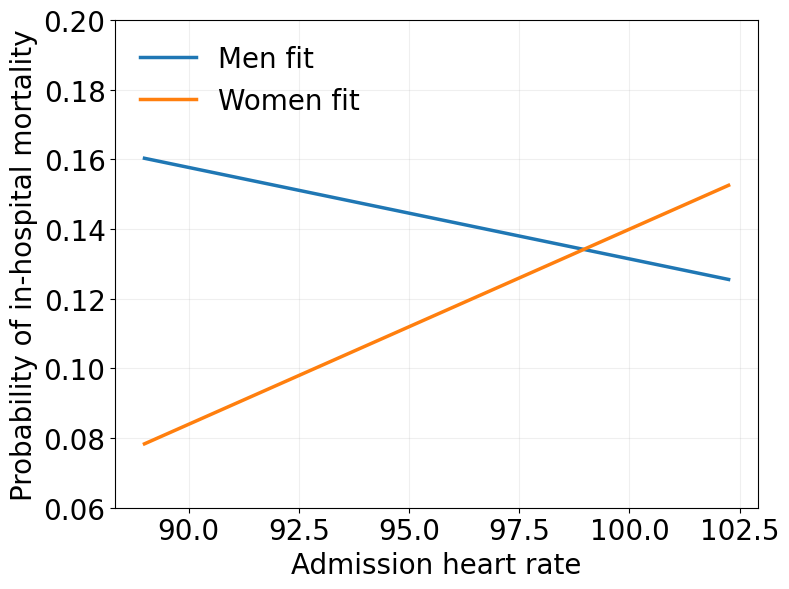

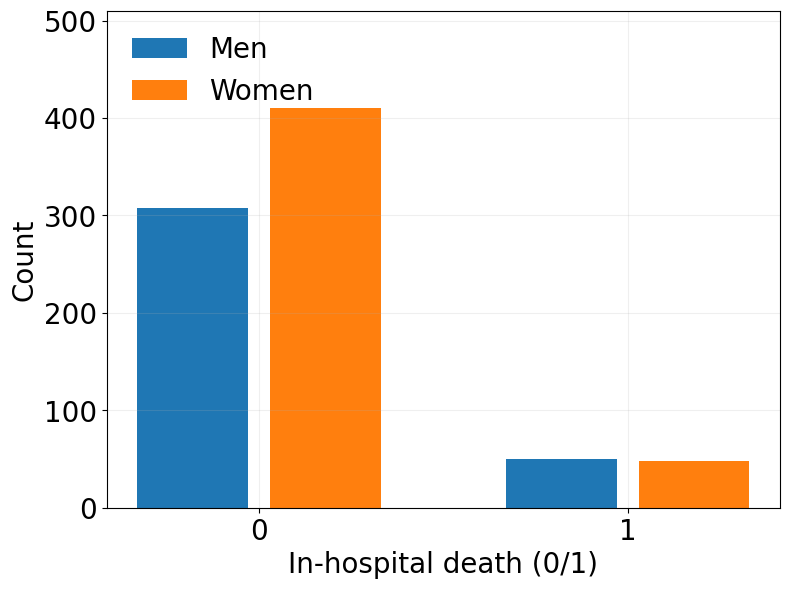

In [34]:
plot_hr_quartile2_lines(
    df_clean=df_clean,
    x_cols=x_cols,
    savepath="Figures/hr_quartile2_mortality_lines.pdf"
)

plot_hr_quartile2_y_hist(
    df_clean=df_clean,
    savepath="Figures/hr_quartile2_mortality_y_hist.pdf"
)